In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

In [2]:
# Load vmem simulation data
base_dir = '/Users/susannedahle/CellTypeDependenceElStim/vmem_data_neo' 

vmem_amp_file_paths = [
    os.path.join(base_dir, f'vmem_amp_data_neo_Ez_{i}.npy')
    for i in range(15)
]

vmem_amp_data_list = [
    np.load(path, allow_pickle=True).item()
    for path in vmem_amp_file_paths
]
vmem_amp_data = {}
for data in vmem_amp_data_list:
    vmem_amp_data.update(data)

In [6]:
def box_plot_morph_properties(sim_data, properties, prop_names): 
    """Loads properties stored during simulation. 
    Plot variation in different neuron-types and print averages in notebook output."""
    
    data = {prop: {'PC': [], 'SS': [], 'Inhibitory': []} for prop in properties}
    
    # Organize data
    for cell, values in sim_data.items():
        for prop in properties:
            if 'PC' in cell or 'SP' in cell:
                data[prop]['PC'].append(values[prop])
            elif 'SS' in cell:
                data[prop]['SS'].append(values[prop])
            else:
                data[prop]['Inhibitory'].append(values[prop])
    
    # Prepare figure
    num_plots = len(properties)
    rows = (num_plots + 2) // 3  
    cols = 3 
    fig, axes = plt.subplots(rows, cols, figsize=(4, 1.5 * rows))
    axes = axes.flatten() 

    colors = {'PC': 'tab:green', 'SS': 'tab:purple', 'Inhibitory': 'tab:orange'}

    # Collect averages for printing
    table_data = []

    for i, prop in enumerate(properties):
        ax = axes[i]
        box = ax.boxplot(
            [data[prop]['PC'], data[prop]['SS'], data[prop]['Inhibitory']], 
            patch_artist=False,
            vert=True,
            showmeans=True,
            meanprops={"marker": "_", "markersize": 3, "markerfacecolor": "black", "markeredgecolor": "black"}
        )
        
        # Set colors
        for idx, (key, color) in enumerate(colors.items(), start=1):
            plt.setp(box['boxes'][idx-1], color=color, linewidth=2)
            plt.setp(box['whiskers'][2*(idx-1):2*idx], color=color)
            plt.setp(box['caps'][2*(idx-1):2*idx], color=color)
            plt.setp(box['medians'][idx-1], color=color)
            plt.setp(box['fliers'][idx-1], marker='o', markersize=3, alpha=0.7, 
                     markerfacecolor=color, markeredgecolor=color)

        ax.set_xticklabels(['Pyr', 'SS', 'Inhb'])
        if prop == 'symmetry_factor' or prop == 'number_of_soma_dendrites':
            ax.set_ylabel(prop_names[prop])
        else:
            ax.set_ylabel(f'{prop_names[prop]} [µm]')
        ax.grid(axis='both', linestyle='--', alpha=0.5, color='gray', linewidth=0.5)

        # Compute averages
        means = {
            "Property": prop_names[prop],
            "Pyramidal mean": np.mean(data[prop]['PC']) if data[prop]['PC'] else np.nan,
            "Pyramidal median": np.median(data[prop]['PC']) if data[prop]['PC'] else np.nan,
            #"Spiny Stellate": np.mean(data[prop]['SS']) if data[prop]['SS'] else np.nan,
            "Inhibitory mean": np.mean(data[prop]['Inhibitory']) if data[prop]['Inhibitory'] else np.nan,
            "Inhibitory median": np.median(data[prop]['Inhibitory']) if data[prop]['Inhibitory'] else np.nan
        }
        table_data.append(means)

    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

    # Print summary table in notebook
    df = pd.DataFrame(table_data)
    pd.set_option("display.precision", 2)  # 2 decimal places
    display(df)


<>:6: SyntaxWarning: invalid escape sequence '\m'
<>:7: SyntaxWarning: invalid escape sequence '\m'
<>:6: SyntaxWarning: invalid escape sequence '\m'
<>:7: SyntaxWarning: invalid escape sequence '\m'
/var/folders/bg/0phzw_wj05x5crg_p858d9b80000gn/T/ipykernel_20249/3990948728.py:6: SyntaxWarning: invalid escape sequence '\m'
  'soma_diam': '$d_\mathrm{s}$',
/var/folders/bg/0phzw_wj05x5crg_p858d9b80000gn/T/ipykernel_20249/3990948728.py:7: SyntaxWarning: invalid escape sequence '\m'
  'avg_z_diam': '$d_\mathrm{d}$'}


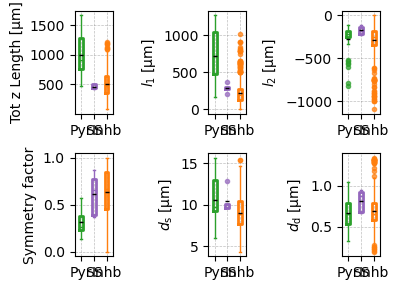

,Property,Pyramidal mean,Pyramidal median,Inhibitory mean,Inhibitory median
0,Tot z Length,998.17,902.47,506.34,475.63
1,$l_1$,720.39,720.31,220.50,191.54
2,$l_2$,-277.78,-222.46,-285.84,-253.82
3,Symmetry factor,0.31,0.26,0.64,0.66
4,$d_\mathrm{s}$,10.61,9.75,9.04,8.87
5,$d_\mathrm{d}$,0.67,0.66,0.69,0.66


In [9]:
properties = ['total_len', 'upper_z_endpoint',  'bottom_z_endpoint', 'symmetry_factor', 'soma_diam', 'avg_z_diam']
prop_names = {'total_len': 'Tot z Length', 
              'upper_z_endpoint': '$l_1$', 
              'bottom_z_endpoint': '$l_2$', 
              'symmetry_factor': 'Symmetry factor', 
              'soma_diam': '$d_\mathrm{s}$',
              'avg_z_diam': '$d_\mathrm{d}$'}

box_plot_morph_properties(vmem_amp_data, properties, prop_names)